<center><h1>Luo_Xiao_FinalProject</h1></center>

Name: Xiao Luo
<br>
Github Username: xluo23
<br>
USC ID: 2392693288

In [54]:
import os
import shutil
import math
from sklearn.model_selection import train_test_split
import cv2
import splitfolders
from tensorflow import keras
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import torch

## 1. Transfer Learning for Video Classification

It is highly recommended that you complete this project using Keras2 and Python.

(a) In this problem, we are trying to build a classifier that distinguishes videos of 5
different activities .

### (b) Video Classification


Videos can be viewed as a sequences of individual images; therefore, one can deal with video classification as performing image classification L times, where L is the number of frames in a video. However, this setting has a problem: it does not capture the temporal nature of the video. That is why we use RNN-CNN for video classification. Training RNN-CNN’s needs a lot of computational resources, and it might sometimes be excessive, so in this project we will take a simpler approach.

### (c) Moving Averages over Predictions for Video Classification

In this approach, we train a CNN for image classification, and turn it into a video classifier using moving averages. If we rely on only one or a few frames of a video for classifying it, we will observe a phenomenon called flickering, which is assigning different labels to different frames of a video in the same class. However, if we use an average of predictions of probabilities for multiple frames, we will get a more reliable prediction for a video.

### (d) Data Exploration and Pre-processing

i. Images in each class are given in separate folders in the folder Sport Images. We have several hundreds of images for five classes of sport activities, namely baseball, basketball, fencing, tennis, and volleyball.

#### ii. Randomly select ⌈0.7ni⌉ images from each folder as your training set, ⌈0.15ni⌉ as validation set, and the rest as your test set, where ni is the number of images in folder i and ⌈x⌉ is the ceiling of x.

In [2]:
images = 'Data/Sport Images'
splitfolders.ratio(images, output="output", seed=1337, ratio=(0.7, 0.15, 0.15)) 

Copying files: 3280 files [00:04, 761.59 files/s]


In [3]:
for path, dirnames, filenames in os.walk('output/'):
    print('{} {} {}'.format(repr(path), repr(dirnames), repr(filenames)))

'output/' ['test', 'train', 'val'] ['.DS_Store']
'output/test' ['baseball', 'basketball', 'volleyball', 'fencing', 'tennis'] ['.DS_Store']
'output/test/baseball' [] ['00000428.jpg', '00000366.jpg', '00000399.jpg', '00000575.jpg', '00000617.jpg', '00000398.jpg', '00000365.jpg', '00000629.jpg', '00000588.jpg', '00000210.jpg', '00000012.jpg', '00000614.jpg', '00000162.jpg', '00000604.jpg', '00000638.jpg', '00000770.jpg', '00000599.jpg', '00000215.jpg', '00000759.jpg', '00000017.jpg', '00000607.png', '00000613.jpg', '00000772.png', '00000202.jpg', '00000766.jpg', '00000438.jpg', '00000311.jpg', '00000675.jpg', '00000271.jpg', '00000502.jpg', '00000072.jpg', '00000476.jpg', '00000338.jpg', '00000676.jpg', '00000070.jpg', '00000500.jpg', '00000703.jpg', '00000471.jpg', '00000048.jpg', '00000706.jpg', '00000666.jpg', '00000114.jpg', '00000062.jpg', '00000506.jpg', '00000739.jpg', '00000077.jpg', '00000668.jpg', '00000683.jpg', '00000046.jpg', '00000278.jpg', '00000287.jpg', '00000251.jpg', '0

#### iii. In order for all the images to have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [4]:
path, dirs, files = next(os.walk("output/"))

for dir in dirs:
    path2 = path + dir
    folders = next(os.walk(path2))[1]
    for folder in folders:
        path3 = path2 + '/' + folder
        files = next(os.walk(path3))[2]
        # print(f'Files in the {folder} folder of the *{dir}* set:', files)
        for file in files:
            image_path = path3 + '/' + file
            # print(image_path)
            img = Image.open(image_path)
            img = img.resize((256,256))
            img.save(image_path)

In [20]:
base_dir = 'output/'
train_dir = os.path.join(base_dir, 'train')
# print(train_dir)
validation_dir = os.path.join(base_dir, 'val')
# print(validation_dir)
test_dir = os.path.join(base_dir, 'test')

### (e) Transfer Learning for Image Classification

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. The dataset in this task has only several hundred images per class. Given that we have 5 classes, training a deep network with such a small dataset may not yield desirable results. In this project, you will use pre-trained models ResNet50, EfficientNetB0, and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

In [21]:
from keras.applications import ResNet50, EfficientNetB0, VGG16
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPool2D, GlobalAveragePooling2D
from tensorflow.python.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Model
from keras.losses import categorical_crossentropy

#### ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, con- trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 90,
    horizontal_flip = True,
    zoom_range=0.2,
    # vertical_flip = True,
    # fill_mode = 'nearest',
    # width_shift_range = 0.8,
    # height_shift_range = 0.7,
    # brightness_range = [0.8, 1.2]
    )

valid_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255)


In [23]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 32, class_mode = 'categorical', target_size=(224,224))
valid_generator = valid_datagen.flow_from_directory(validation_dir, batch_size = 32, class_mode = 'categorical', target_size=(224,224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size = 32, class_mode='categorical', target_size=(224, 224))


Found 2281 images belonging to 5 classes.
Found 486 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


#### iii. Use ReLU activation functions in the last layer and a softmax layer, along with batch normalization and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

##### VGG16

In [9]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False)

x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions_vgg16 = Dense(5, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)

for layer in base_model_vgg16.layers:
    layer.trainable = False

model_vgg16.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

##### ResNet50

In [10]:
# Create base model
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False)

# Add new top layers to the base model
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions_resnet50 = Dense(5, activation='softmax')(x)

# Define complete models with new top layers
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions_resnet50)

# Freeze all layers in the base models
for layer in base_model_resnet50.layers:
    layer.trainable = False
    
# Compile models with ADAM optimizer and multinomial cross-entropy loss
model_resnet50.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

##### EfficientNetB0

In [46]:
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)

x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
predictions_efficientnet = Dense(5, activation='softmax')(x)

model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=predictions_efficientnet)

for layer in base_model_efficientnet.layers:
    layer.trainable = False

model_efficientnet.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

#### iv. Train the networks ResNet50, EfficientNetB0, and VGG16 for at least 50 epochs (preferably 100 epochs) and perform early stopping using the valida- tion set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [12]:
import matplotlib.pyplot as plt

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### VGG16

In [51]:
history_vgg16 = model_vgg16.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[es], verbose=1, batch_size=32)

Epoch 1/50


2023-05-08 20:38:01.891940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - ETA: 0s - loss: 1.2136 - accuracy: 0.5313

2023-05-08 20:46:19.799144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - 601s 8s/step - loss: 1.2136 - accuracy: 0.5313 - val_loss: 1.3016 - val_accuracy: 0.5206
Epoch 2/50
72/72 [==============================] - 561s 8s/step - loss: 1.0309 - accuracy: 0.5967 - val_loss: 1.1467 - val_accuracy: 0.6584
Epoch 3/50
72/72 [==============================] - 540s 8s/step - loss: 0.9289 - accuracy: 0.6418 - val_loss: 1.0078 - val_accuracy: 0.7181
Epoch 4/50
72/72 [==============================] - 548s 8s/step - loss: 0.8982 - accuracy: 0.6563 - val_loss: 0.9014 - val_accuracy: 0.7243
Epoch 5/50
72/72 [==============================] - 542s 8s/step - loss: 0.8210 - accuracy: 0.6971 - val_loss: 0.7987 - val_accuracy: 0.7366
Epoch 6/50
72/72 [==============================] - 542s 8s/step - loss: 0.8154 - accuracy: 0.6918 - val_loss: 0.7349 - val_accuracy: 0.7510
Epoch 7/50
72/72 [==============================] - 541s 8s/step - loss: 0.7972 - accuracy: 0.7001 - val_loss: 0.7085 - val_accuracy: 0.7469
Epoch 8/50
72/72 [======

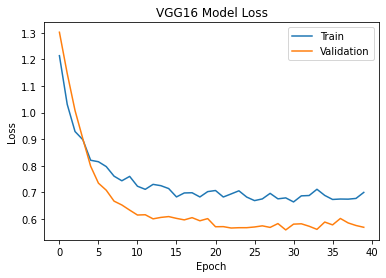

In [52]:
# Plot training and validation loss
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

##### ResNet50

In [15]:
history_resnet50 = model_resnet50.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[es], verbose=1, batch_size=32)

Epoch 1/50


2023-05-08 15:35:14.148233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - ETA: 0s - loss: 1.5901 - accuracy: 0.2828

2023-05-08 15:39:38.224571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - 314s 4s/step - loss: 1.5901 - accuracy: 0.2828 - val_loss: 1.6023 - val_accuracy: 0.1996
Epoch 2/50
72/72 [==============================] - 274s 4s/step - loss: 1.4952 - accuracy: 0.3534 - val_loss: 1.5605 - val_accuracy: 0.3416
Epoch 3/50
72/72 [==============================] - 230s 3s/step - loss: 1.4487 - accuracy: 0.3626 - val_loss: 1.5062 - val_accuracy: 0.3807
Epoch 4/50
72/72 [==============================] - 234s 3s/step - loss: 1.4153 - accuracy: 0.3911 - val_loss: 1.4888 - val_accuracy: 0.3745
Epoch 5/50
72/72 [==============================] - 242s 3s/step - loss: 1.4130 - accuracy: 0.3814 - val_loss: 1.4409 - val_accuracy: 0.3951
Epoch 6/50
72/72 [==============================] - 245s 3s/step - loss: 1.3904 - accuracy: 0.4200 - val_loss: 1.4119 - val_accuracy: 0.4095
Epoch 7/50
72/72 [==============================] - 281s 4s/step - loss: 1.4037 - accuracy: 0.3981 - val_loss: 1.3802 - val_accuracy: 0.4547
Epoch 8/50
72/72 [======

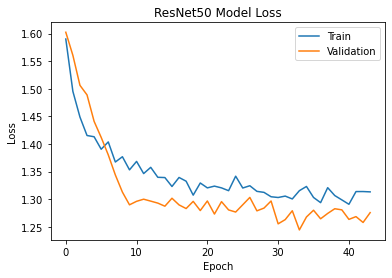

In [39]:
# Plot training and validation loss
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

##### EfficientNetB0

In [47]:
history_efficientnet = model_efficientnet.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[es], verbose=1, batch_size=32)

Epoch 1/50


2023-05-08 19:22:26.923818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - ETA: 0s - loss: 2.0634 - accuracy: 0.2109

2023-05-08 19:24:32.081490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - 147s 2s/step - loss: 2.0634 - accuracy: 0.2109 - val_loss: 1.6059 - val_accuracy: 0.1934
Epoch 2/50
72/72 [==============================] - 131s 2s/step - loss: 1.9733 - accuracy: 0.2183 - val_loss: 1.5982 - val_accuracy: 0.2222
Epoch 3/50
72/72 [==============================] - 115s 2s/step - loss: 1.9138 - accuracy: 0.2139 - val_loss: 1.5955 - val_accuracy: 0.2160
Epoch 4/50
72/72 [==============================] - 118s 2s/step - loss: 1.8511 - accuracy: 0.2249 - val_loss: 1.5929 - val_accuracy: 0.2263
Epoch 5/50
72/72 [==============================] - 114s 2s/step - loss: 1.8260 - accuracy: 0.2170 - val_loss: 1.5909 - val_accuracy: 0.2407
Epoch 6/50
72/72 [==============================] - 116s 2s/step - loss: 1.7792 - accuracy: 0.2131 - val_loss: 1.5847 - val_accuracy: 0.2346
Epoch 7/50
72/72 [==============================] - 117s 2s/step - loss: 1.7525 - accuracy: 0.2262 - val_loss: 1.5780 - val_accuracy: 0.2613
Epoch 8/50
72/72 [======

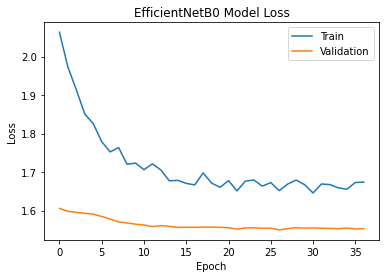

In [49]:
# Plot training and validation loss
plt.plot(history_efficientnet.history['loss'])
plt.plot(history_efficientnet.history['val_loss'])
plt.title('EfficientNetB0 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### v. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on both training and test sets. Remember that this is a multi-class classification problem.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

##### VGG16

In [53]:
train_preds = np.argmax(model_vgg16.predict(train_generator), axis=-1)
test_preds = np.argmax(model_vgg16.predict(test_generator), axis=-1)

train_labels = train_generator.classes
test_labels = test_generator.classes

train_cm = confusion_matrix(train_labels, train_preds)
test_cm = confusion_matrix(test_labels, test_preds)
train_acc = accuracy_score(train_labels, train_preds)
test_acc = accuracy_score(test_labels, test_preds)
train_f1 = f1_score(train_labels,train_preds, average='weighted')
test_f1 = f1_score(test_labels,test_preds, average='weighted')
train_prec = precision_score(train_labels, train_preds, average='weighted')
test_prec = precision_score(test_labels, test_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

print("Confusion Matrix for Training Set:\n", train_cm)
print('\nThe accuracy, precision, recall, F1-score for training set:')
print(f'Accuracy: {train_acc}') 
print(f'Precision: {train_prec}')
print(f'Recall: {train_recall}') 
print(f'F1-score: {train_f1}')

print("\nConfusion Matrix for Test Set:\n", test_cm)
print('\nThe accuracy, precision, recall, F1-score for test set:')
print(f'Accuracy: {test_acc}') 
print(f'Precision: {test_prec}')
print(f'Recall: {test_recall}') 
print(f'F1-score: {test_f1}')

2023-05-09 10:34:27.394142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - 557s 8s/step


2023-05-09 10:43:44.916277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 119s 7s/step
Confusion Matrix for Training Set:
 [[124  74  98 108 108]
 [ 87  46  57  72  81]
 [ 99  73  93  88  82]
 [109  57  91 106 137]
 [ 93  74 107  98 119]]

The accuracy, precision, recall, F1-score for training set:
Accuracy: 0.21394125383603682
Precision: 0.2133112285077857
Recall: 0.21394125383603682
F1-score: 0.21350039930721817

Confusion Matrix for Test Set:
 [[29 14 27 18 23]
 [20  9 10 18 17]
 [17 14 15 19 30]
 [29 20 21 20 18]
 [21 19 16 26 25]]

The accuracy, precision, recall, F1-score for test set:
Accuracy: 0.19797979797979798
Precision: 0.19713757340471882
Recall: 0.19797979797979798
F1-score: 0.19741091352014295


##### ResNet50

In [36]:
train_preds = np.argmax(model_resnet50.predict(train_generator), axis=-1)
test_preds = np.argmax(model_resnet50.predict(test_generator), axis=-1)

train_labels = train_generator.classes
test_labels = test_generator.classes

2023-05-08 19:11:27.563332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - 217s 3s/step


2023-05-08 19:15:04.659036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 42s 3s/step


In [38]:
# Calculate the confusion matrix, precision, recall, accuracy, and F1 score for the training and test sets
train_cm = confusion_matrix(train_labels, train_preds)
test_cm = confusion_matrix(test_labels, test_preds)
train_acc = accuracy_score(train_labels, train_preds)
test_acc = accuracy_score(test_labels, test_preds)
train_f1 = f1_score(train_labels,train_preds, average='weighted')
test_f1 = f1_score(test_labels,test_preds, average='weighted')
train_prec = precision_score(train_labels, train_preds, average='weighted')
test_prec = precision_score(test_labels, test_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

print("Confusion Matrix for Training Set:\n", train_cm)
print('\nThe accuracy, precision, recall, F1-score for training set:')
print(f'Accuracy: {train_acc}') 
print(f'Precision: {train_prec}')
print(f'Recall: {train_recall}') 
print(f'F1-score: {train_f1}')

print("\nConfusion Matrix for Test Set:\n", test_cm)
print('\nThe accuracy, precision, recall, F1-score for test set:')
print(f'Accuracy: {test_acc}') 
print(f'Precision: {test_prec}')
print(f'Recall: {test_recall}') 
print(f'F1-score: {test_f1}')

Confusion Matrix for Training Set:
 [[178  41  92  75 126]
 [127  34  61  41  80]
 [152  41  77  70  95]
 [175  38  89  67 131]
 [172  43  90  68 118]]

The accuracy, precision, recall, F1-score for training set:
Accuracy: 0.20780359491451117
Precision: 0.20348498807452628
Recall: 0.20780359491451117
F1-score: 0.19903076938061223

Confusion Matrix for Test Set:
 [[38 10 23 14 26]
 [29  9 14  4 18]
 [26 11 27  9 22]
 [35 17 24  7 25]
 [46 11 19  9 22]]

The accuracy, precision, recall, F1-score for test set:
Accuracy: 0.2080808080808081
Precision: 0.19820071576519954
Recall: 0.2080808080808081
F1-score: 0.1949498863191557


##### EfficientNetB0

In [50]:
train_preds = np.argmax(model_efficientnet.predict(train_generator), axis=-1)
test_preds = np.argmax(model_efficientnet.predict(test_generator), axis=-1)

train_labels = train_generator.classes
test_labels = test_generator.classes

train_cm = confusion_matrix(train_labels, train_preds)
test_cm = confusion_matrix(test_labels, test_preds)
train_acc = accuracy_score(train_labels, train_preds)
test_acc = accuracy_score(test_labels, test_preds)
train_f1 = f1_score(train_labels,train_preds, average='weighted')
test_f1 = f1_score(test_labels,test_preds, average='weighted')
train_prec = precision_score(train_labels, train_preds, average='weighted')
test_prec = precision_score(test_labels, test_preds, average='weighted')
train_recall = recall_score(train_labels, train_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

print("Confusion Matrix for Training Set:\n", train_cm)
print('\nThe accuracy, precision, recall, F1-score for training set:')
print(f'Accuracy: {train_acc}') 
print(f'Precision: {train_prec}')
print(f'Recall: {train_recall}') 
print(f'F1-score: {train_f1}')

print("\nConfusion Matrix for Test Set:\n", test_cm)
print('\nThe accuracy, precision, recall, F1-score for test set:')
print(f'Accuracy: {test_acc}') 
print(f'Precision: {test_prec}')
print(f'Recall: {test_recall}') 
print(f'F1-score: {test_f1}')

2023-05-08 20:30:40.268813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


72/72 [==============================] - 95s 1s/step


2023-05-08 20:32:15.291166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 18s 1s/step
Confusion Matrix for Training Set:
 [[138   0   0 340  34]
 [103   0   0 214  26]
 [128   0   0 270  37]
 [146   1   0 311  42]
 [160   0   0 295  36]]

The accuracy, precision, recall, F1-score for training set:
Accuracy: 0.21262604120999562
Precision: 0.13784415983451495
Recall: 0.21262604120999562
F1-score: 0.14610726987862518

Confusion Matrix for Test Set:
 [[46  0  0 50 15]
 [32  0  0 26 16]
 [30  0  0 45 20]
 [32  0  0 57 19]
 [49  0  0 36 22]]

The accuracy, precision, recall, F1-score for test set:
Accuracy: 0.25252525252525254
Precision: 0.16438219126828094
Recall: 0.25252525252525254
F1-score: 0.193806699600014


/Users/luoxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luoxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### (f) Video Classification Using Moving Averages


#### i. In order to have a better deep learner, reuse the validation and test data and train the network, without seriously overfitting it. In the lectures, we saw how this can be done.


##### EfficientNetB0

In [67]:
history2_efficientnet = model_efficientnet.fit(valid_generator, epochs=50, validation_data=valid_generator, callbacks=[es], verbose=1, batch_size=32)

2023-05-09 18:05:37.774228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.6161 - accuracy: 0.2510

2023-05-09 18:06:04.929789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 47s 3s/step - loss: 1.6161 - accuracy: 0.2510 - val_loss: 1.5532 - val_accuracy: 0.2798
Epoch 2/50
16/16 [==============================] - 51s 3s/step - loss: 1.6386 - accuracy: 0.2284 - val_loss: 1.5540 - val_accuracy: 0.2613
Epoch 3/50
16/16 [==============================] - 49s 3s/step - loss: 1.6481 - accuracy: 0.2202 - val_loss: 1.5539 - val_accuracy: 0.2613
Epoch 4/50
16/16 [==============================] - 44s 3s/step - loss: 1.6815 - accuracy: 0.2407 - val_loss: 1.5525 - val_accuracy: 0.2613
Epoch 5/50
16/16 [==============================] - 43s 3s/step - loss: 1.6729 - accuracy: 0.2222 - val_loss: 1.5551 - val_accuracy: 0.2510
Epoch 6/50
16/16 [==============================] - 39s 3s/step - loss: 1.6145 - accuracy: 0.2572 - val_loss: 1.5528 - val_accuracy: 0.2613
Epoch 7/50
16/16 [==============================] - 40s 3s/step - loss: 1.6369 - accuracy: 0.2243 - val_loss: 1.5519 - val_accuracy: 0.2613
Epoch 8/50
16/16 [=============

In [68]:
history3_efficientnet = model_efficientnet.fit(test_generator, epochs=50, validation_data=valid_generator, callbacks=[es], verbose=1, batch_size=32)

Epoch 1/50


2023-05-09 18:34:31.026733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - ETA: 0s - loss: 1.6734 - accuracy: 0.2525

2023-05-09 18:34:55.633721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


16/16 [==============================] - 43s 3s/step - loss: 1.6734 - accuracy: 0.2525 - val_loss: 1.5490 - val_accuracy: 0.2840
Epoch 2/50
16/16 [==============================] - 43s 3s/step - loss: 1.6515 - accuracy: 0.2424 - val_loss: 1.5492 - val_accuracy: 0.3313
Epoch 3/50
16/16 [==============================] - 43s 3s/step - loss: 1.6644 - accuracy: 0.2101 - val_loss: 1.5564 - val_accuracy: 0.3004
Epoch 4/50
16/16 [==============================] - 43s 3s/step - loss: 1.6552 - accuracy: 0.2768 - val_loss: 1.5522 - val_accuracy: 0.3107
Epoch 5/50
16/16 [==============================] - 43s 3s/step - loss: 1.6708 - accuracy: 0.2263 - val_loss: 1.5534 - val_accuracy: 0.3251
Epoch 6/50
16/16 [==============================] - 43s 3s/step - loss: 1.6757 - accuracy: 0.2323 - val_loss: 1.5532 - val_accuracy: 0.3560
Epoch 7/50
16/16 [==============================] - 43s 3s/step - loss: 1.6556 - accuracy: 0.2323 - val_loss: 1.5528 - val_accuracy: 0.3621
Epoch 8/50
16/16 [=============


#### ii. Apply at least L equally spaced frames of each video in the folder Sport Videos to your model to obtain L vectors of probability predictions from the softmax in your model. You must choose L to be at least 100, but you are welcome to use all the frames in each video. Calculate the average p ̄ of these probability vectors for each video.


In [62]:
predictions = []
labels = []

for layer in model_efficientnet.layers[:-1]:
    layer.trainable = False

avg_prob_vectors = []
L = 100
base_path = 'Data/Sport Videos/'
activities = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']

for activity in activities:
    act_path = os.path.join(base_path, activity)

    for filename in os.listdir(act_path):
        video_path = os.path.join(act_path, filename)

        cap = cv2.VideoCapture(video_path)
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frames_ind = np.linspace(0, total_frames-1, L, dtype=int)
        frames = []
        video_prob_vectors = []

        for i, frame_ind in enumerate(frames_ind):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_ind)
            ret, frame = cap.read()
            if ret:
                frames.append(frame)
            if len(frames) == L:
                break
            
            if frame is not None:
                frame = cv2.resize(frame, (224, 224))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) / 255.0
                prob_vector = model_efficientnet.predict(np.expand_dims(frame, axis=0))[0]
                video_prob_vectors.append(prob_vector)
            else:
                pass
        avg_prob_vector = np.mean(video_prob_vectors, axis=0)
        avg_prob_vectors.append(avg_prob_vector)

        class_index = np.argmax(avg_prob_vector)
        class_name = activities[class_index]
    
        predictions.append(class_name)
        labels.append(filename.split('_')[1])
        
        cap.release()

1/1 [==============================] - 0s 105ms/step


#### iii. Select the class with maximum probability in the vector p ̄ for each video and compare it to the actual label of the video.


In [63]:
print('Predictions:', predictions)
print('Labels:', labels)

Predictions: ['BaseballPitch', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'BaseballPitch', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'BaseballPitch', 'TennisSwing', 'TennisSwing', 'BaseballPitch', 'BaseballPitch', 'TennisSwing', 'Tenn

#### iv. Report the Confusion Matrix, Precision, Recall, Accuracy, and F1 score for your model on the test data, i.e. videos. Remember that this is a multi-class classification problem.

In [66]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(labels, predictions)
cr = classification_report(labels, predictions)

print('Confusion Matrix:\n', cm)
print('\nClassification Report:\n', cr)

Confusion Matrix:
 [[ 40   0   0 110   0]
 [ 39   0   0  98   0]
 [ 30   0   0  81   0]
 [ 39   0   0 128   0]
 [ 34   0   0  82   0]]

Classification Report:
                    precision    recall  f1-score   support

    BaseballPitch       0.22      0.27      0.24       150
       Basketball       0.00      0.00      0.00       137
          Fencing       0.00      0.00      0.00       111
      TennisSwing       0.26      0.77      0.38       167
VolleyballSpiking       0.00      0.00      0.00       116

         accuracy                           0.25       681
        macro avg       0.10      0.21      0.13       681
     weighted avg       0.11      0.25      0.15       681



/Users/luoxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luoxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luoxiao/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
